In [1]:
# Import required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# Read in personal Streaming History data
# SH0_df contains data from partner 0 that will be used for building the ML models
# SH1_df are data from partner 1 that will be used in prediction
SH0_df = pd.read_csv("partner0_StreamingHist.csv")
SH1_df = pd.read_csv("partner1_StreamingHist.csv")

# Read in Song Attributes data
df_attr = pd.read_csv("song_attributes.csv")

SH0_df.shape, SH1_df.shape, df_attr.shape

((15344, 5), (11424, 5), (169909, 19))

In [3]:
# Some data cleaning to remove some special characters ([,],',") in the 'artists' column in the raw data of 'song attributes' 
df_attr['artists'] = df_attr['artists'].replace({r'\[|\]|\'|\"':''}, regex=True)
df_attr = df_attr.rename(columns={'name':'track'})
SH0_df = SH0_df.rename(columns={'artistName':'artists', 'trackName':'track'}).drop('Unnamed: 0', axis=1)
SH1_df = SH1_df.rename(columns={'artistName':'artists', 'trackName':'track'}).drop('Unnamed: 0', axis=1)


In [71]:
# Short-list only songs from SH0_df that also have 'song attributes' data
sl_df0 = pd.merge(SH0_df, df_attr[['track', 'artists']], how='inner', on=['track', 'artists'])

#comb_df0 = comb_df0[comb_df0['danceability'].notnull()]
#len(sl_df0)

sl_df0.head(5)

,endTime,artists,track,msPlayed
0,30/07/2019 13:40,The Blue Nile,Tinseltown in the Rain,306831.0
1,30/07/2019 14:18,David Gray,Babylon,265666.0
2,10/12/2019 07:02,David Gray,Babylon,265666.0
3,01/01/2020 21:54,David Gray,Babylon,1300.0
4,20/01/2020 09:15,David Gray,Babylon,265666.0


In [76]:
sl_df0.groupby(['track','artists'])['msPlayed'].sum().to_frame('tot_msPlayed').reset_index()

#ax=sl_df0.groupby(['track','artists'])['msPlayed'].sum().to_frame('tot_msPlayed').reset_index().plot(kind='hist', bins=500)
#ax.set_xlim(0,2000000)

,track,artists,tot_msPlayed
0,"""45""",The Gaslight Anthem,207546.0
1,"""Heroes"" - Live; 2005 Remaster",David Bowie,145900.0
2,'Helden' - German Version 1989 Remix; 2002 Rem...,David Bowie,2206917.0
3,(Everybody Wanna Get Rich) Rite Away,Dr. John,26002.0
4,(Feels Like) Heaven,Fiction Factory,214048.0
...,...,...,...
2095,wish you were gay,Billie Eilish,443086.0
2096,xanny,Billie Eilish,256464.0
2097,you should see me in a crown,Billie Eilish,542856.0
2098,守得云开见月明 - Every cloud has a silver lining,Yue Yan Jen,393000.0


(0.0, 20.0)

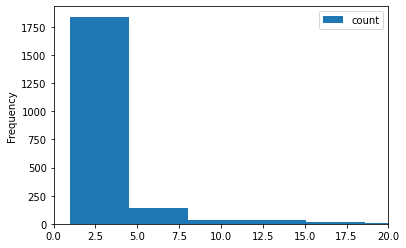

In [113]:
ax=sl_df0.groupby(['track', 'artists']).size().to_frame('count').reset_index().plot(kind='hist', bins=40)
ax.set_xlim(0,20)

In [114]:
# Count the number of occurences of each song in the short-listed data
df0_fav = sl_df0.groupby(['track', 'artists'])['track'].count().to_frame('count').reset_index()
df0_fav.head(10)

,track,artists,count
0,"""45""",The Gaslight Anthem,1
1,"""Heroes"" - Live; 2005 Remaster",David Bowie,1
2,'Helden' - German Version 1989 Remix; 2002 Rem...,David Bowie,12
3,(Everybody Wanna Get Rich) Rite Away,Dr. John,1
4,(Feels Like) Heaven,Fiction Factory,2
5,(I Can't Get No) Satisfaction - Mono Version,The Rolling Stones,4
6,"(Si, Si) Je Suis Un Rock Star",Bill Wyman,2
7,(Sittin' On) The Dock Of The Bay - Remastered ...,Glen Campbell,4
8,(You Make Me Feel Like) A Natural Woman,Aretha Franklin,2
9,(Your Love Keeps Lifting Me) Higher & Higher,Jackie Wilson,2


In [115]:
df0_fav[df0_fav['count'] >= 5].tail(5)

,track,artists,count
2026,You Can Call Me Al,Paul Simon,8
2028,You Can't Hurry Love - 2016 Remaster,Phil Collins,46
2042,You Make My Dreams (Come True),Daryl Hall & John Oates,10
2072,Your Song,Elton John,6
2079,bad guy,Billie Eilish,41


In [116]:
# Save songs with 5 or more occurrences/listens as 1 ('favourite')
df0_fav = sl_df0.groupby(['track', 'artists'])['track'].count().to_frame('count').reset_index()

df0_fav['favourite'] = np.where(df0_fav['count'] >= 5, 1, 0)
df0_fav = df0_fav.drop('count', axis=1)



In [272]:
# merging 'favourite' column into the 'song attributes' datafile (this returns only songs that parter 0 (SH0) had listened to in the previous year)
df0 = pd.merge(df0_fav, df_attr, how='left', on=['track', 'artists'])
df0.drop(columns = ['id', 'key', 'mode', 'release_date', "explicit", "year"], inplace=True)
df0.head(5)


,track,artists,favourite,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,popularity,speechiness,tempo,valence
0,"""45""",The Gaslight Anthem,0,0.000696,0.315,202493,0.970,0.00000,0.2770,-4.709,48,0.1020,178.068,0.423
1,"""Heroes"" - Live; 2005 Remaster",David Bowie,0,0.028800,0.489,374533,0.814,0.02100,0.8010,-7.705,30,0.0323,114.211,0.738
2,'Helden' - German Version 1989 Remix; 2002 Rem...,David Bowie,1,0.000085,0.444,220707,0.674,0.25400,0.1160,-7.791,49,0.0298,112.459,0.485
3,(Everybody Wanna Get Rich) Rite Away,Dr. John,0,0.518000,0.746,163933,0.916,0.06860,0.0785,-10.061,53,0.0772,99.926,0.971
4,(Feels Like) Heaven,Fiction Factory,0,0.198000,0.542,214047,0.820,0.00172,0.0497,-10.982,45,0.0512,116.666,0.762


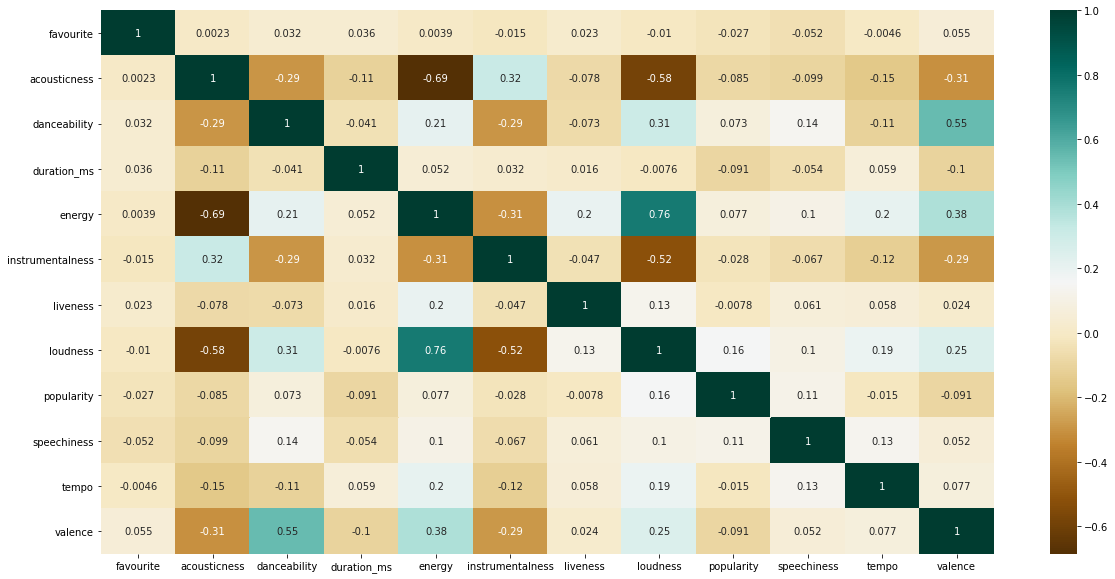

In [159]:
# Correlation matrix of Song Features

plt.figure(figsize=(20,10))
c = df0.drop(columns = ["track", "artists"]).corr()
corr = sns.heatmap(c, cmap="BrBG", annot=True)


In [160]:
df0.favourite.value_counts()

0    2309
1     463
Name: favourite, dtype: int64

## Model Selection with Cross-validation and Hyperparameter Tuning

In [161]:
# Importing required libraries
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
from sklearn.metrics import f1_score
# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE


In [162]:
# Train / Split Data
X_train, X_test, y_train, y_test = train_test_split(df0.drop(columns=["track", "artists", "favourite"]), df0["favourite"], test_size=.20)

In [163]:
# Scale Features To Reduce potential biases towards certain features during learning 
## algorithms that fit a model using a weighted sum of input variables are especially affected, such as linear regression, logistic regression, and artificial neural networks 
mmscaler = MinMaxScaler()

X_train_scaled = mmscaler.fit_transform(X_train)
X_test_scaled = mmscaler.transform(X_test)


In [168]:
# Apply SMOTE

oversample = SMOTE()
X_train_scaled,y_train = oversample.fit_resample(X_train_scaled,y_train)


For each model, cross-validation is used to see how well each model generalises and obtain a F1 score.

In [211]:
%%time
# Logistic Regression
lr = LogisticRegression()
lr_scores = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring="f1", n_jobs=-1, verbose=2)
#np.mean(lr_scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Wall time: 2.62 s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


In [179]:
np.mean(lr_scores)

0.5724940179252818

In [216]:
# Hyperparameter optimization for Decision Tree Classifier
parameters = {
    'max_depth':[15,20,30],
}
dtc = Pipeline([('CV',GridSearchCV(DecisionTreeClassifier(random_state=13), parameters, cv = 5, scoring="f1"))])
dtc.fit(X_train_scaled, y_train)
dtc.named_steps['CV'].best_params_

{'max_depth': 30}

In [217]:
# Decision Tree
dt = DecisionTreeClassifier(max_depth=30)
dt_scores = cross_val_score(dt, X_train_scaled, y_train, cv=10, scoring="f1", n_jobs=-1, verbose=2)
np.mean(dt_scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished


0.8033582899028457

In [218]:
# Hyperparameter optimization of RandomForestClassifier
parameters = {
    'max_depth':[6,12,15,20],
    'n_estimators':[20,30]
}
clf = Pipeline([('CV',GridSearchCV(RandomForestClassifier(random_state=13), parameters, cv = 5, scoring="f1"))])
clf.fit(X_train_scaled, y_train)
clf.named_steps['CV'].best_params_

{'max_depth': 20, 'n_estimators': 30}

In [220]:
# Cross-validation for RandomForestClassifier
rf = Pipeline([('rf', RandomForestClassifier(n_estimators = 20, max_depth = 30, random_state=13))])
rf_scores = cross_val_score(rf, X_train_scaled, y_train, cv=10, scoring="f1", n_jobs=-1, verbose=2)
np.mean(rf_scores)

0.9053167586855009

In [234]:
from sklearn.neural_network import MLPClassifier

parameters = {
    'alpha':[0.001],    #tested[0.0001, 0.005, 0.01, 0.05, 0.01, 0.1, 1.0, 5.0]
    'hidden_layer_sizes': [[100, 100], [100,150]]    # tested [[100,50], [150, 50], [100,10], [100, 20], [100,10], [50, 10], [10, 10]]
}

mlpc = Pipeline([('CV', GridSearchCV(MLPClassifier(random_state=13), parameters, cv=5, scoring="f1", n_jobs=-1, verbose=2))])
mlpc.fit(X_train_scaled, y_train)
mlpc.named_steps['CV'].best_params_
#clf1 = MLPClassifier(random_state=13 , hidden_layer_sizes = [10,10]) #solver - defaults is 'adam'
#grid_values = {'alpha': [0.01, 0.1, 1.0, 5.0]}    #also tried this combination [0.001, 0.005, 0.01, 0.05] and the best param is still 0.01
               

# metric to optimize over grid parameters: AUC
#grid_clf_auc = GridSearchCV(clf1, param_grid = grid_values, scoring = 'roc_auc')

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   49.4s finished
C:\Users\DrJKLau\anaconda3\envs\opencvenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


{'alpha': 0.001, 'hidden_layer_sizes': [100, 150]}

In [235]:
# Cross-validation for RandomForestClassifier
mlp = Pipeline([('mlp', MLPClassifier(random_state=13, alpha = 0.001, hidden_layer_sizes = (100,150)))])
mlp_scores = cross_val_score(mlp, X_train_scaled, y_train, cv=10, scoring="f1", n_jobs=-1, verbose=2)
np.mean(mlp_scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.0min finished


0.8113635643727101

In [265]:
from sklearn.svm import SVC

parameters = {
    'C':[5, 10, 20, 50],    #for linear, tested[0.001, 0.01, 0.1, 1, 5]  #for rbf, test [0.01, 0.5, 0.1, 1, 5, 10, 20, 50, 100, 200, 500, 1500]
    'gamma': [20, 50, 80]  #for rbf, test [0.01, 0.1, 0.5, 1, 10, 50, 100, 150]
}

svc_clf = Pipeline([('CV', GridSearchCV(SVC(random_state=13, kernel="rbf"), parameters, cv=5, scoring="f1", n_jobs=-1, verbose=2))])
svc_clf.fit(X_train_scaled, y_train)
svc_clf.named_steps['CV'].best_params_

#svc_clf = SVC(random_state=13 , kernel="linear", class_weight = "balanced") #solver - defaults is 'adam'
#grid_values = {'C': [0.04, 0.05, 0.1, 0.5, 1, 5, 20, 40]} #also tried this combination [0.01, 0.1, 1, 5] when not using class_weight and the best param was 0.01 
#               
#
## metric to optimize over grid parameters: AUC
#grid_clf_auc = GridSearchCV(clf1, param_grid = grid_values, scoring = "roc_auc")
#grid_clf_auc.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    8.5s finished


{'C': 20, 'gamma': 50}

In [266]:
svc = Pipeline([('svc', SVC(random_state=13, C = 20, gamma=50, kernel="rbf"))])   #class_weight = "balanced"
svc_scores = cross_val_score(svc, X_train_scaled, y_train, cv=10, scoring="f1", n_jobs=-1, verbose=2)
np.mean(svc_scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s finished


0.9636242183243647

### Testing SVC model with the test set

In [267]:
svc.fit(X_train_scaled, y_train)

Pipeline(steps=[('svc', SVC(C=20, gamma=50, random_state=13))])

In [268]:
y_pred = svc.predict(X_test_scaled)

In [269]:
from sklearn.metrics import f1_score

f1_score(y_test, y_pred, average=None)

array([0.90704801, 0.30534351])

### Testing RandomForestClassifier model with the test set

In [207]:
rf.fit(X_train_scaled, y_train)

Pipeline(steps=[('rf', RandomForestClassifier(max_depth=30, n_estimators=20))])

In [208]:
y_pred = rf.predict(X_test_scaled)

In [209]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

f1_score(y_test, y_pred, average=None)
#confusion_matrix(y_test, y_pred)

array([0.91880342, 0.56321839])

In [60]:
#sl_df1 = pd.merge(SH1_df, df_attr[['track', 'artists']], how='inner', on=['track', 'artists'])

#comb_df1 = comb_df1[comb_df1['danceability'].notnull()]

#ax=comb_df1.groupby(['track', 'artists']).size().to_frame('count').reset_index().plot(kind='hist', bins=40)
#ax.set_xlim(0,40)

In [275]:
df1_freq = SH1_df.groupby(['track', 'artists'])['track'].count().to_frame('count').reset_index()

In [69]:
df1 = pd.merge(df1_freq, df_attr, how='inner', on=['track', 'artists'])
df1.drop('count', axis=1, inplace=True)

In [270]:
df1.head(5)

,track,artists,acousticness,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,popularity,release_date,speechiness,tempo,valence,year
0,...Baby One More Time,Britney Spears,0.1850,0.757,211160,0.725,0,7EFVJfuaqhIIvzNHZpEpth,0.000056,0,0.568,-4.860,0,38,2004,0.0315,92.960,0.883,2004
1,...Baby One More Time,Britney Spears,0.2020,0.759,211067,0.699,0,3MjUtNVVq3C8Fn0MP3zhXa,0.000131,0,0.443,-5.745,0,77,1999-01-12,0.0307,92.960,0.907,1999
2,...Ready For It?,Taylor Swift,0.0527,0.613,208187,0.764,0,2yLa0QULdQr0qAIvVwN6B5,0.000000,2,0.197,-6.509,1,71,2017-11-10,0.1360,160.015,0.417,2017
3,17,Julia Michaels,0.4580,0.774,182800,0.466,0,0ND8rF8oirMXtE59n585P6,0.000000,4,0.111,-6.869,1,73,2019-06-28,0.0433,97.975,0.396,2019
4,18,One Direction,0.2200,0.681,248360,0.582,0,3JjnGLK8IxkNLvo8Lb3KOM,0.000000,6,0.119,-7.760,0,79,2014-11-17,0.0313,124.038,0.221,2014
